In [1]:
''' Data collection for characterizing Quick Current Sensor

    Use keithley 177/179 with USB adapter to collect data.
    Use DC load to step current

'''

import os
import serial
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import StandardScaler

current_dmm_port = '/dev/ttyUSB0'
voltage_dmm_port = '/dev/ttyUSB1'

current_dmm_range = 1E-1    # how many decimal places to shift
voltage_dmm_range = 1E-3

serBaud = 115200
serTimeout = 2

# Open both ports
currentDmm = serial.Serial(port=current_dmm_port, baudrate=serBaud, timeout=serTimeout)
voltageDmm = serial.Serial(port=voltage_dmm_port, baudrate=serBaud, timeout=serTimeout)


Colleciton Duration: 110 seconds
Number Of Samples: 110

vout = 0.003 * current + 0.015
3.3mV/mA


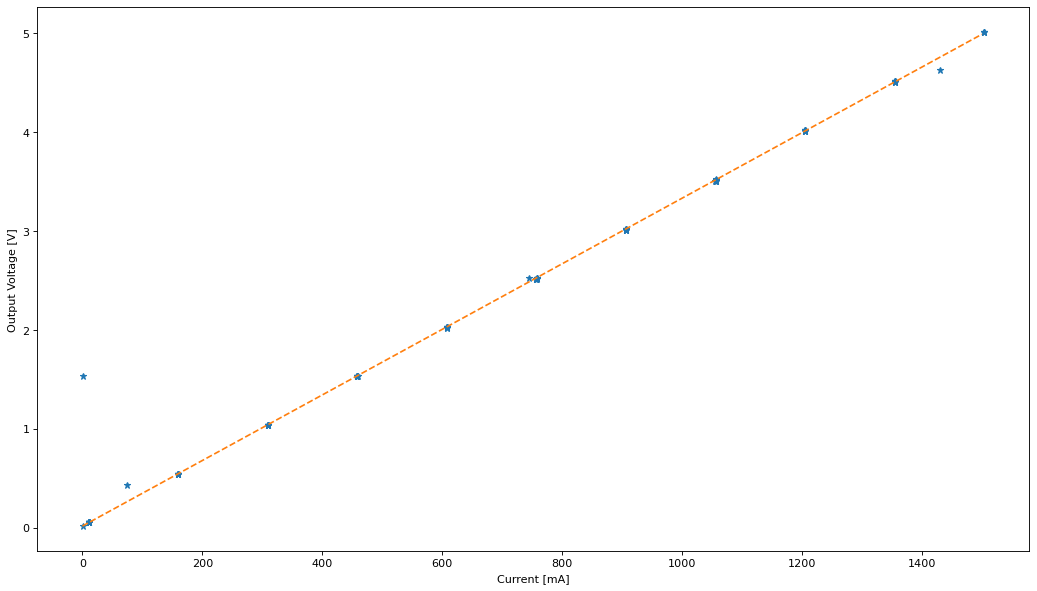

In [6]:
sample_duration = 110  #seconds
delay_between_samples = 1 #seconds
print_as_sampling = False

nSamples = int(sample_duration / delay_between_samples)

print("Colleciton Duration: {} seconds".format(sample_duration))
print("Number Of Samples: {}\n".format(nSamples))
print("Collecting Data...")

# Open ports if they are closed
if (currentDmm.is_open == False):
    currentDmm.open()
if (voltageDmm.is_open == False):
    voltageDmm.open()

time.sleep(1)

current_list = []
voltage_list = []

for n in range(0, nSamples):

    currentDmm.reset_input_buffer()
    cval = currentDmm.readline().decode('ascii')
    try:
        cint = int(cval.lstrip('\x00').rstrip('\r\n'))
    except:
        cint = 0
        
    current_float = cint * current_dmm_range

    voltageDmm.reset_input_buffer()
    vval = voltageDmm.readline().decode('ascii')
    try:
        vint = int(vval.lstrip('\x00').rstrip('\r\n'))
    except:
        vint = 0
        
    voltage_float = vint * voltage_dmm_range
    
    if (print_as_sampling):
        print("Current: {:.3f}, Voltage: {:.3f}".format(current_float, voltage_float))
    
    current_list.append(current_float)
    voltage_list.append(voltage_float)
    
    time.sleep(delay_between_samples)

currentDmm.close()
voltageDmm.close()

# Get a transfer funciton
# https://stackoverflow.com/questions/61143998/numpy-best-fit-line-with-outliers

# make np array for data wrangling
x = np.array(current_list)
y = np.array(voltage_list)

# standardize    
x_scaler, y_scaler = StandardScaler(), StandardScaler()
x_train = x_scaler.fit_transform(x[..., None])
y_train = y_scaler.fit_transform(y[..., None])

# fit model
model = HuberRegressor(epsilon=1)
model.fit(x_train, y_train.ravel())

# do some predictions
test_x = np.array([0, 1500])
predictions = y_scaler.inverse_transform(model.predict(x_scaler.transform(test_x[..., None])))

# use polyfit to get transfer funciton
z = np.polyfit(test_x, predictions, 1)
print('vout = {:.3f} * current + {:.3f}'.format(z[0], z[1]))
print('{:.1f}mV/mA'.format(z[0] * 1000))

# plot
fig, ax = plt.subplots(figsize=(16,9), dpi=80)

ax.plot(x, y, '*')
ax.plot(test_x, predictions, '--')

ax.set_xlabel('Current [mA]')
ax.set_ylabel('Output Voltage [V]')

plt.show()